## Import the necessary libraries:

In [1]:
#to do unsupervised clustering analysis
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib notebook

import math
import numpy as np

pd.set_option('float_format', '{:f}'.format)

## Set global variables used in clustering:

In [2]:
# Ensure there is always a predefined random_state so every run has same outputs
random_state = 100
# We need to divide accounts into 4 groups
clusters=4

## Read the excel files:

In [4]:
df_Acc_Rev = pd.read_excel(open('../ISDataAnalysis/NolanReport2.xlsx','rb'), sheet_name='ClientRevenue')
df_Sbl_Acc = pd.read_excel(open('../ISDataAnalysis/NolanSblAccReport.xlsx','rb'), sheet_name='SblClients')
df_Hbl_Client = pd.read_excel(open('../ISDataAnalysis/NolanReport2.xlsx','rb'), sheet_name='Hubble')
df_Opty_Data = pd.read_excel(open('../ISDataAnalysis/NolanCMReport.xlsx','rb'), sheet_name='OptyData')

## Fix excel data. Namely fix the names, change types to String:

In [5]:
df_Acc_Rev['ACCOUNT_NUM'] = df_Acc_Rev['ACCOUNT_NUM'].astype(str)
df_Sbl_Acc['ACCOUNT_NUM'] = df_Sbl_Acc['ACCOUNT_NUM'].astype(str)
df_Sbl_Acc['MASTER_NUM'] = df_Sbl_Acc['MASTER_NUM'].astype(str)
df_Hbl_Client["ACCOUNT_NUM"] = df_Hbl_Client["ACCOUNT_NUM"].astype(str)
df_Hbl_Client["HBL_CLIENT"] = df_Hbl_Client["HBL_CLIENT"].map(lambda x: x.lstrip().rstrip())
df_Sbl_Acc["SBL_MASTER"] = df_Sbl_Acc["SBL_MASTER"].map(lambda x: x.lstrip().rstrip())

## Join Client data from Siebel and Hubble:

In [6]:
df_Client_Join = pd.merge(
    df_Sbl_Acc, df_Hbl_Client, on='ACCOUNT_NUM', how='outer')
df_Client_Join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3819 entries, 0 to 3818
Data columns (total 7 columns):
ACCOUNT_ID     3804 non-null object
ACCOUNT_NUM    3819 non-null object
ACCOUNT        3804 non-null object
MASTER_ID      3804 non-null object
MASTER_NUM     3804 non-null object
SBL_MASTER     3804 non-null object
HBL_CLIENT     1307 non-null object
dtypes: object(7)
memory usage: 238.7+ KB


## Check record validity:
Get accounts that are either not in Hubble or in Siebel.
Create another column called MASTER that has Hubble account name, and if its not available have Siebel Account name

In [7]:
df_NotInSiebel = df_Client_Join[df_Client_Join.ACCOUNT_ID.isnull()]
df_NotInHubble = df_Client_Join[df_Client_Join.HBL_CLIENT.isnull()]
df_Client_Join["MASTER"] = df_Client_Join.apply(
    lambda row: row["SBL_MASTER"] if pd.isnull(row["HBL_CLIENT"]) else row["HBL_CLIENT"], axis = 1
)
df_Client = df_Client_Join[["ACCOUNT_NUM","MASTER"]]
df_Client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3819 entries, 0 to 3818
Data columns (total 2 columns):
ACCOUNT_NUM    3819 non-null object
MASTER         3819 non-null object
dtypes: object(2)
memory usage: 89.5+ KB


## Join Client and Revenue data to get one data frame:

In [8]:
df_Rev = pd.merge(df_Client, df_Acc_Rev, on="ACCOUNT_NUM", how="outer")
#df_Client_Without_Rev = df_Rev[df_Rev.REVENUE.isnull()]
#df_Acc_Without_Client = df_Rev[df_Rev.MASTER.isnull()]
df_Client_Rev = df_Rev.groupby(["MASTER"]) \
        .agg({"REVENUE":"sum", "ACCOUNT_NUM": "count"}) \
        .reset_index()\
        .rename(columns={"ACCOUNT_NUM":"ACCOUNT_COUNT"})
df_Zero_Client_Rev = df_Client_Rev[df_Client_Rev["REVENUE"] == 0]
df_Non_Zero_Client_Rev = df_Client_Rev[df_Client_Rev["REVENUE"] != 0]
df_Non_Zero_Client_Rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, 0 to 3176
Data columns (total 3 columns):
MASTER           805 non-null object
REVENUE          805 non-null float64
ACCOUNT_COUNT    805 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 25.2+ KB


## Join Client and Opportunity data:

In [9]:
df = pd.merge(df_Client_Join, df_Opty_Data, on='ACCOUNT_ID', how='left')
df_min = df[["MASTER","OPTY_ID", "OPTY_TYPE","PROBABILITY", "OPTY_REVENUE"]]
df_min_opty = df_min[~df_min["OPTY_ID"].isnull()]
df_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19201 entries, 0 to 19200
Data columns (total 5 columns):
MASTER          19201 non-null object
OPTY_ID         16487 non-null object
OPTY_TYPE       16487 non-null object
PROBABILITY     16502 non-null float64
OPTY_REVENUE    16502 non-null float64
dtypes: float64(2), object(3)
memory usage: 900.0+ KB


## There are some accounts that have no activity. Check them here:

In [10]:
df_mst_agg = df_min.groupby(["MASTER"]) \
        .agg({"OPTY_ID": "count", "OPTY_REVENUE":"sum"}) \
        .reset_index()\
        .rename(columns={"OPTY_ID":"OPTY_CNT", "OPTY_REVENUE":"OPTY_REV_SUM"})

no_activity_accounts = pd.merge(df_Non_Zero_Client_Rev, df_mst_agg, on="MASTER", how="left")
no_activity_accounts.drop_duplicates(inplace=True)
no_activity_accounts = no_activity_accounts[no_activity_accounts['OPTY_CNT']==0]
no_activity_accounts.sort_values('REVENUE',inplace=True,ascending=False)
no_activity_accounts.reset_index(inplace=True)
#no_act_acc_with_rev = no_act_acc_with_rev[['ACCOUNT_NUM', 'ACCOUNT', 'REVENUE']]

### Do unsupervised clustering of NEW SALES using two methods, KMeans and GaussianMixture:

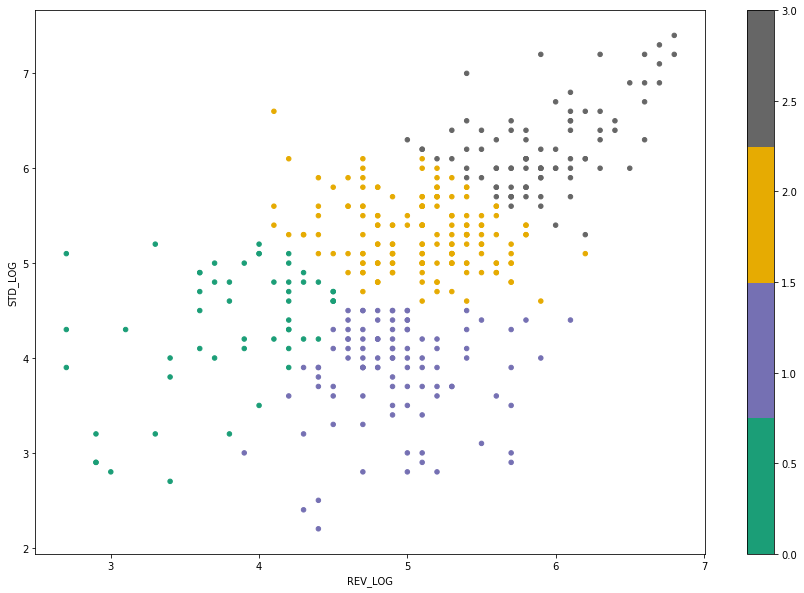

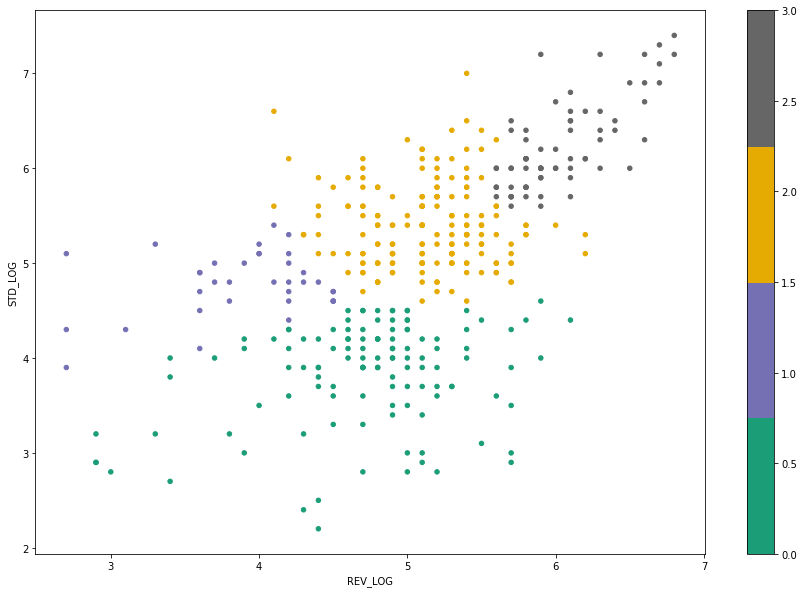

In [11]:
df_Std_Sale = pd.merge(df_min_opty, df_Non_Zero_Client_Rev, on="MASTER", how="left")
df_Std_Sale.drop_duplicates(keep='first',inplace=True)
df_Std_Sale = df_Std_Sale[(df_Std_Sale['PROBABILITY']>=90) \
                          & ((df_Std_Sale['OPTY_TYPE'] == 'Standard Sale') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'Upgrade') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'STC Value Up') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'BID') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'Emergency Install') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'New Logo') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'Complex Sale') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'Emergency Change') \
                          | (df_Std_Sale['OPTY_TYPE'] == 'STC Conversion')) \
                          & (df_Std_Sale['OPTY_REVENUE'] > 0) \
                          & (df_Std_Sale['REVENUE']>0)]
df_Std_Sale = df_Std_Sale.groupby(['MASTER'])\
                          .agg({'OPTY_ID':'count', 'OPTY_REVENUE': 'sum', 'REVENUE': 'max'})\
                          .reset_index()\
                          .rename(columns={'COUNT':'OPTY_REV'})
df_Std_Sale['STD_LOG'] = np.around(np.log10(df_Std_Sale['OPTY_REVENUE']),decimals=1)
df_Std_Sale['REV_LOG'] = np.around(np.log10(df_Std_Sale['REVENUE']),decimals=1)

#--------------Using KMeans unsupervised clustering------------------
KM_nsl_model = KMeans(n_clusters=clusters, random_state = random_state)
KM_nsl_fit = KM_nsl_model.fit(df_Std_Sale[['STD_LOG','REV_LOG']])
#df_Std_Sale.loc[:,'KM_LABELS'] = KM_nsl_fit.labels_

#Sort the labels
idx = np.argsort(KM_nsl_fit.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(clusters)
df_Std_Sale.loc[:,'KM_LABELS'] = lut[KM_nsl_fit.labels_]

fig, ax = plt.subplots() #To fix x_axis scale issue
plt_new = df_Std_Sale.plot(kind="scatter", x="REV_LOG", y="STD_LOG", c=df_Std_Sale["KM_LABELS"], \
                           figsize=(15,10),cmap=plt.cm.get_cmap('Dark2', 4),ax=ax)
ax.set_xlabel("REV_LOG")
plt.show()

#--------------Using GaussianMixture unsupervised clustering---------
GM_nsl_model = GaussianMixture(n_components=clusters, random_state = random_state)
GM_nsl_fit = GM_nsl_model.fit(df_Std_Sale[['STD_LOG','REV_LOG']])
#df_Std_Sale.loc[:,'GM_LABELS'] = GM_nsl_fit.predict(df_Std_Sale[['STD_LOG','REV_LOG']])

#Sort the labels
idx = np.argsort(GM_nsl_fit.means_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(clusters)
df_Std_Sale.loc[:,'GM_LABELS'] = lut[GM_nsl_fit.predict(df_Std_Sale[['STD_LOG','REV_LOG']])]

fig, ax = plt.subplots() #To fix x_axis scale issue
plt_new = df_Std_Sale.plot(kind="scatter", x="REV_LOG", y="STD_LOG", c=df_Std_Sale["GM_LABELS"], \
                           figsize=(15,10),cmap=plt.cm.get_cmap('Dark2', 4), ax=ax)
ax.set_xlabel("REV_LOG")
plt.show()

### Do unsupervised clustering of Churn data using two methods, KMeans and GaussianMixture:

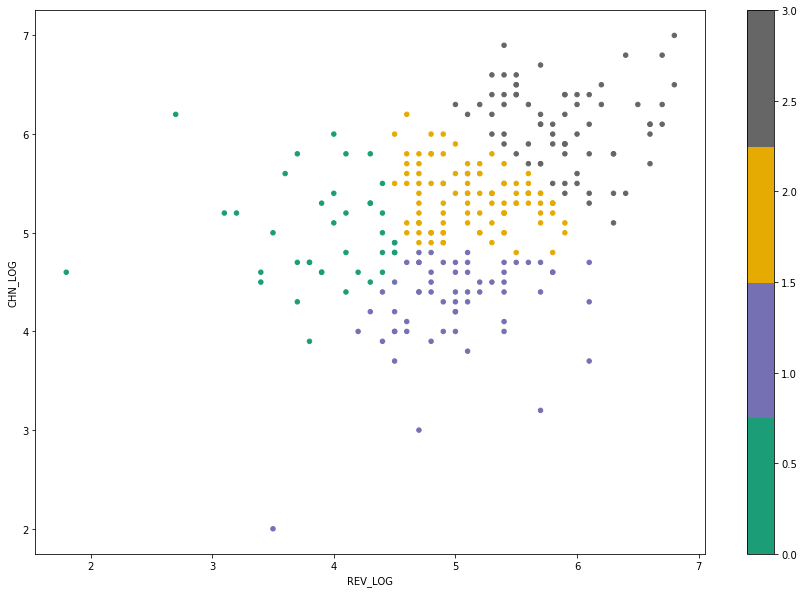

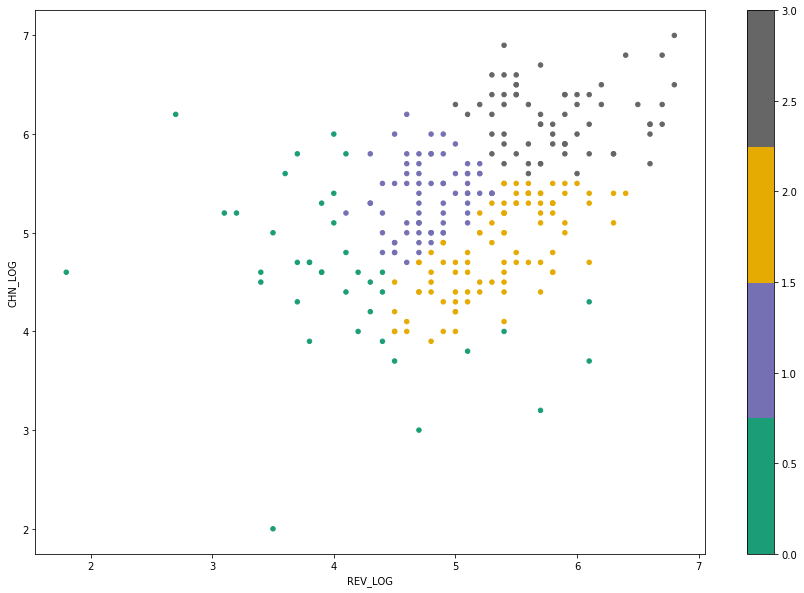

In [12]:
df_Chn = pd.merge(df_min_opty, df_Non_Zero_Client_Rev, on="MASTER", how="left")
df_Chn.drop_duplicates(keep='first',inplace=True)
df_Chn = df_Chn[(df_Chn['PROBABILITY']>=90) \
                          & ((df_Chn['OPTY_TYPE'] == 'Churn')
                          | (df_Chn['OPTY_TYPE'] == 'STC Value Down')
                          | (df_Chn['OPTY_TYPE'] == 'LEGAL DECOM')
                          | (df_Chn['OPTY_TYPE'] == 'Suspect Churn')
                          | (df_Chn['OPTY_TYPE'] == 'Downgrade')) \
                          & (df_Chn['OPTY_REVENUE'] < 0) \
                          & (df_Chn['REVENUE']>0)]
df_Chn = df_Chn.groupby(['MASTER'])\
                          .agg({'OPTY_ID':'count', 'OPTY_REVENUE': 'sum', 'REVENUE': 'max'})\
                          .reset_index()\
                          .rename(columns={'COUNT':'OPTY_REV'})
df_Chn['CHN_LOG'] = np.around(np.log10(np.abs(df_Chn['OPTY_REVENUE'])),decimals=1)
df_Chn['REV_LOG'] = np.around(np.log10(df_Chn['REVENUE']),decimals=1)

#Using KMeans unsupervised clustering
KM_chn_model = KMeans(n_clusters=clusters, random_state = random_state)
KM_chn_fit = KM_chn_model.fit(df_Chn[['CHN_LOG','REV_LOG']])
#df_Chn.loc[:,'KM_LABELS'] = KM_chn_fit.labels_

#Sort the labels
idx = np.argsort(KM_chn_fit.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(clusters)
df_Chn.loc[:,'KM_LABELS'] = lut[KM_chn_fit.labels_]

fig, ax = plt.subplots() #To fix x_axis scale issue
plt_new = df_Chn.plot(kind="scatter", x="REV_LOG", y="CHN_LOG", c=df_Chn["KM_LABELS"], \
                           figsize=(15,10),cmap=plt.cm.get_cmap('Dark2', 4),ax=ax)
ax.set_xlabel("REV_LOG")
plt.show()

#Using GaussianMixture unsupervised clustering
GM_chn_model = GaussianMixture(n_components=clusters, random_state = random_state)
GM_chn_fit = GM_chn_model.fit(df_Chn[['CHN_LOG','REV_LOG']])
#df_Chn.loc[:,'GM_LABELS'] = GM_chn_fit.predict(df_Chn[['CHN_LOG','REV_LOG']])

#Sort the labels
idx = np.argsort(GM_chn_fit.means_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(clusters)
df_Chn.loc[:,'GM_LABELS'] = lut[GM_chn_fit.predict(df_Chn[['CHN_LOG','REV_LOG']])]

fig, ax = plt.subplots() #To fix x_axis scale issue
plt_new = df_Chn.plot(kind="scatter", x="REV_LOG", y="CHN_LOG", c=df_Chn["GM_LABELS"], \
                           figsize=(15,10),cmap=plt.cm.get_cmap('Dark2', 4), ax=ax)
ax.set_xlabel("REV_LOG")
plt.show()

In [13]:
with pd.ExcelWriter("ClientInfo.xlsx") as writer:
    writer.date_format = None  # <--- Workaround for date formatting
    writer.datetime_format = None  # <--- this one for datetime
    df_NotInHubble.to_excel(writer, "NOT_IN_HUBBLE")
    df_NotInSiebel.to_excel(writer, "NOT_IN_SIEBEL")
    df_Zero_Client_Rev.to_excel(writer, "ZERO_REV_CLIENT")
    df_Non_Zero_Client_Rev.to_excel(writer, "CLIENT_REVENUE")
    no_activity_accounts.to_excel(writer, "DORMANT_ACCOUNTS")
    df_Std_Sale.to_excel(writer,'STD_SALE_GRP')
    df_Chn.to_excel(writer,'CHN_GRP')

In [14]:
#df_Std_Sale.LABELS.value_counts()
print(df_Chn.KM_LABELS.value_counts())
print(df_Chn.GM_LABELS.value_counts())

2    90
1    73
3    56
0    29
Name: KM_LABELS, dtype: int64
2    83
1    71
3    47
0    47
Name: GM_LABELS, dtype: int64


## Getting Cluster Centres

In [15]:
print(KM_nsl_fit.cluster_centers_)
print(GM_nsl_fit.means_)
print("For Churn:")
print(KM_chn_fit.cluster_centers_)
print(GM_chn_fit.means_)

[[6.1673913  5.87065217]
 [5.14836601 5.05882353]
 [4.1225     3.65      ]
 [3.78494624 4.90215054]]
[[5.92946254 5.84758024]
 [4.03636573 4.95363207]
 [4.9499979  4.34609347]
 [5.14205411 5.14313693]]
For Churn:
[[5.41222222 5.21888889]
 [5.04482759 3.76551724]
 [4.39041096 4.91643836]
 [6.13571429 5.975     ]]
[[5.14655505 5.49157503]
 [4.67263787 4.47581141]
 [5.18293702 4.84680789]
 [6.23264697 5.81370843]]


In [16]:
np.sort(KM_nsl_fit.cluster_centers_,axis=0)

array([[3.78494624, 3.65      ],
       [4.1225    , 4.90215054],
       [5.14836601, 5.05882353],
       [6.1673913 , 5.87065217]])